# Modelo de AVC (stroke)

# Variável resposta (target)

- stroke                - binária

# Variáveis "já prontas"

- heart_disease         - binária
- hypertension          - binária

# Variáveis tratadas

- ever_married          - binária
- Residence_type        - binária
- gender                - binária
- age                   - discreta
- work_type             - múltiplas categorias
- avg_glucose_level     - contínua
- bmi                   - contínua
- smoking_status        - múltiplas categorias

# Variáveis removidas

- id

In [ ]:
import pandas as pd
import kagglehub
import os

# Download latest version
stroke = "fedesoriano/stroke-prediction-dataset"
hearth = "fedesoriano/heart-failure-prediction"

def carregar_df_kaggle(caminho):
    # carregando o conjunto de dados
    caminho = kagglehub.dataset_download(caminho)
    arquivo = os.listdir(caminho)[0]
    caminho_final = os.path.join(caminho, arquivo)
    df = pd.read_csv(caminho_final)

    # verificando descritiva
    print(df.describe())
    print(df.sample(5))
    return df

# dados de avc (stroke)
df_stroke = carregar_df_kaggle(stroke)

                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0

## Utilização do sweetviz para EDA e tratamento dos dados de stroke

In [ ]:
#!pip install sweetviz

In [ ]:
#!pip install numpy==1.23.5

                                             |          | [  0%]   00:00 -> (? left)


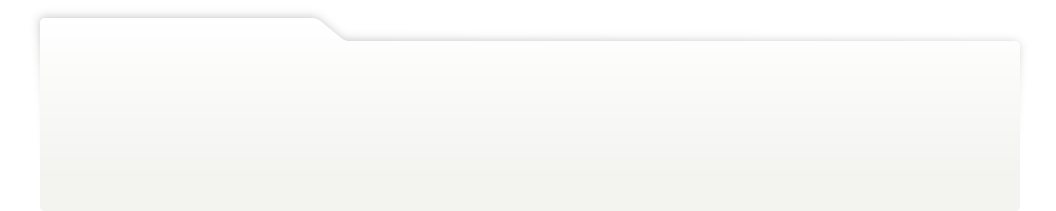
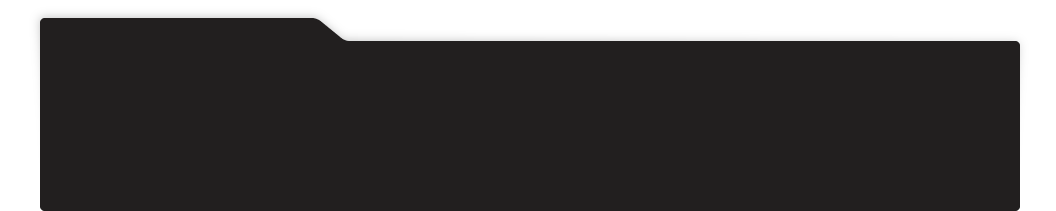
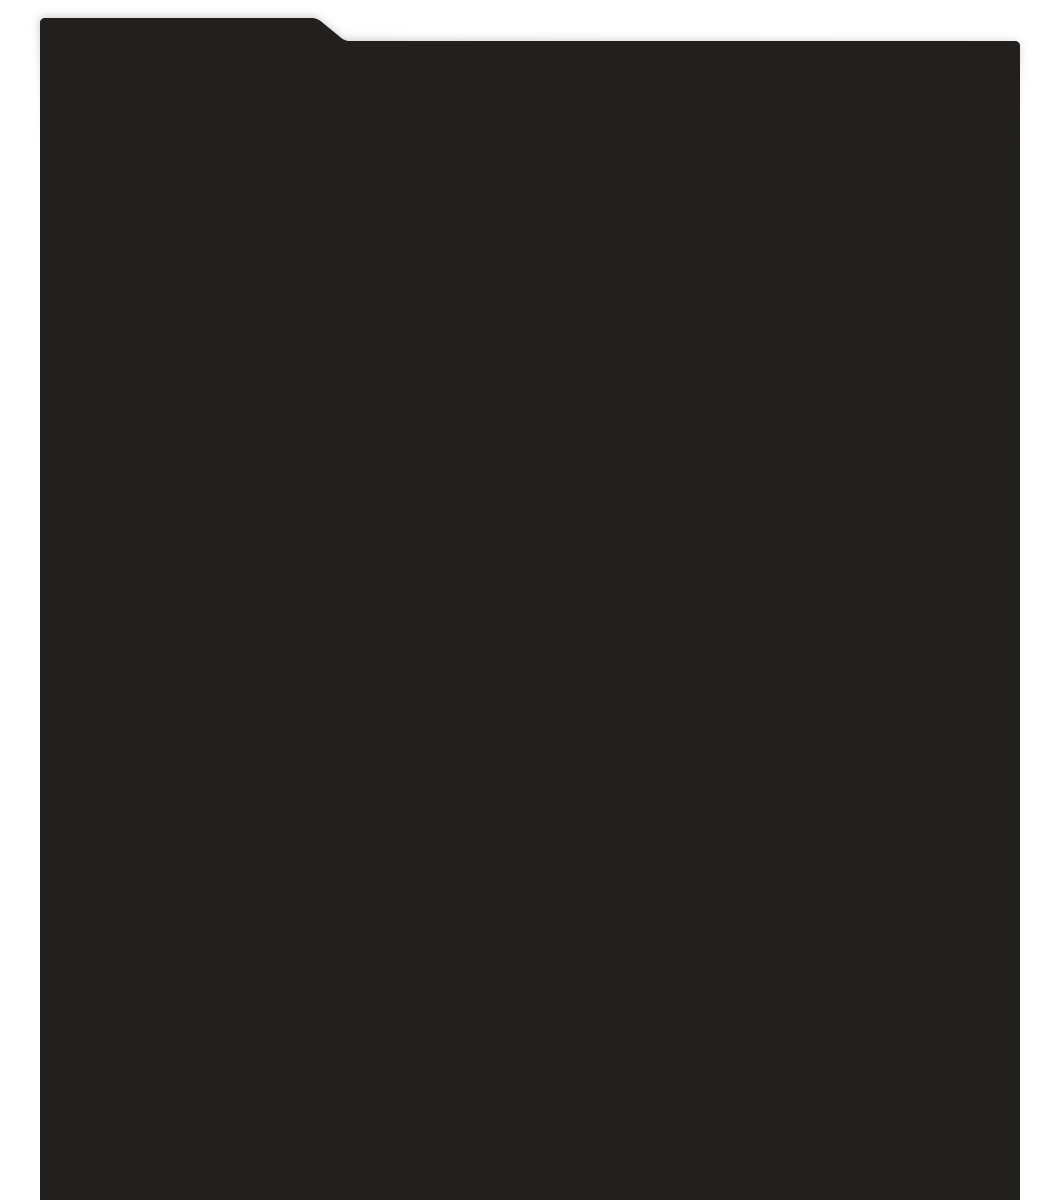
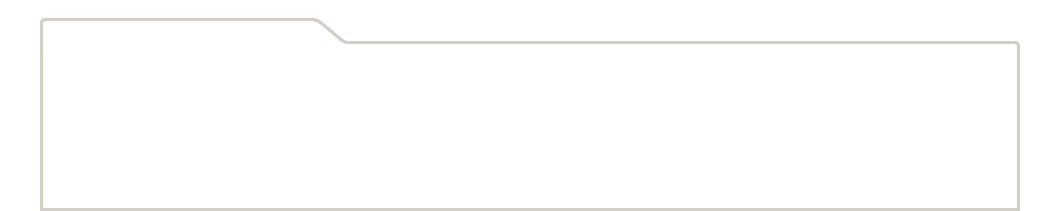
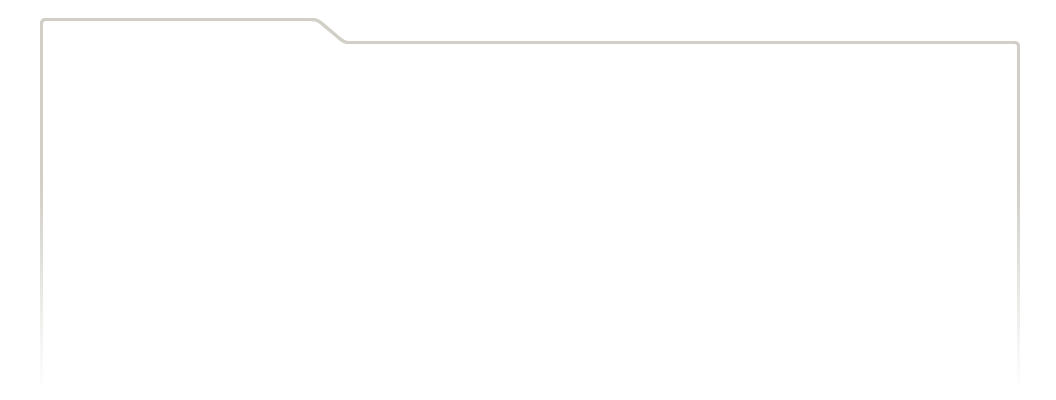
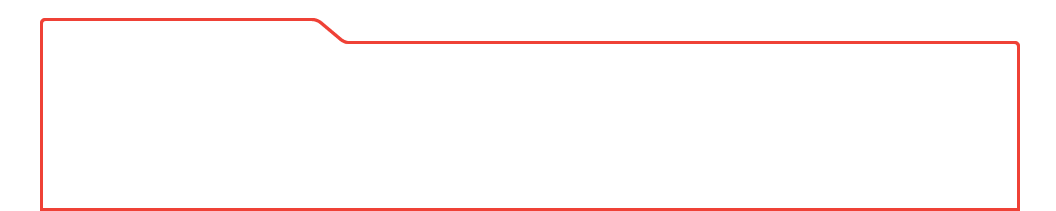
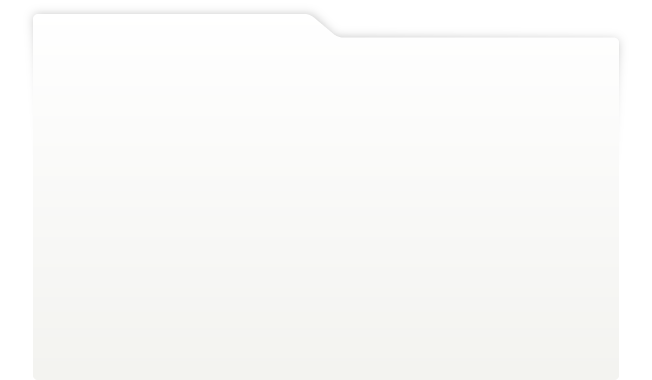
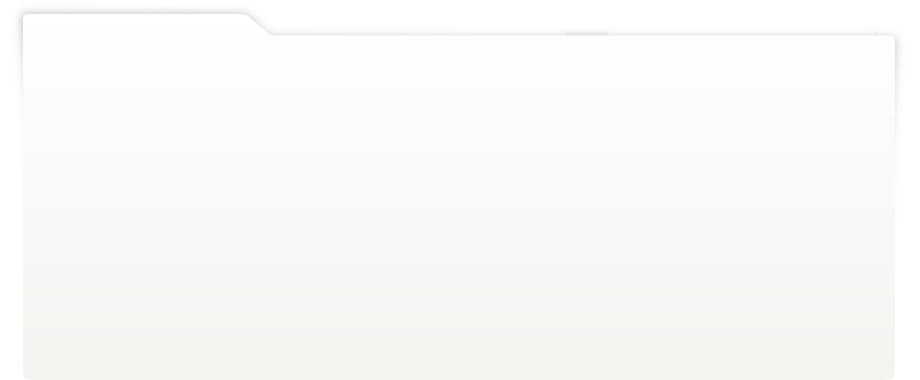
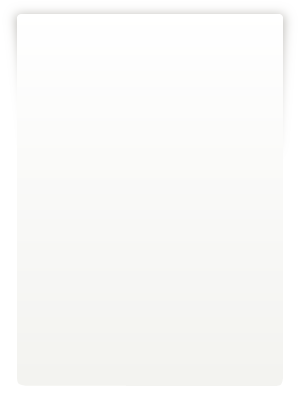
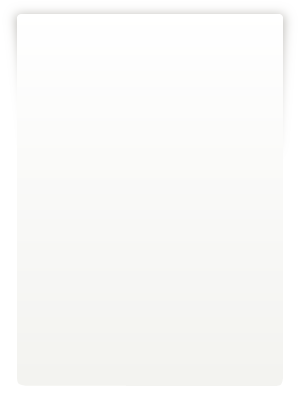
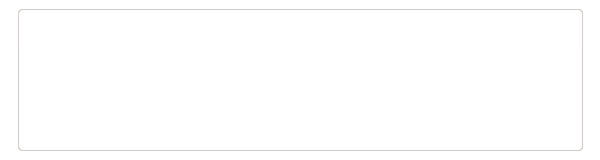
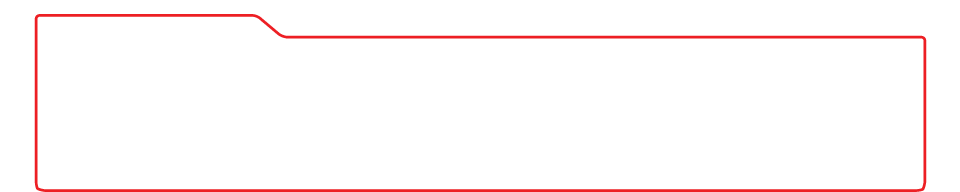
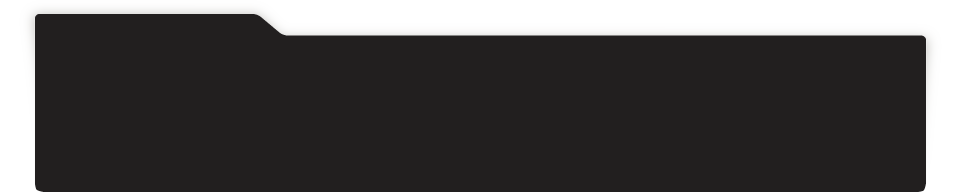
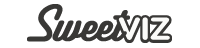
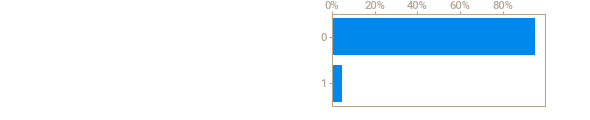
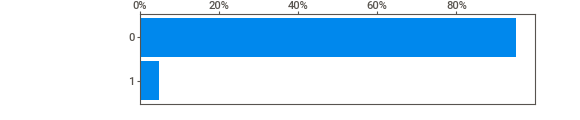
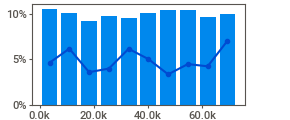
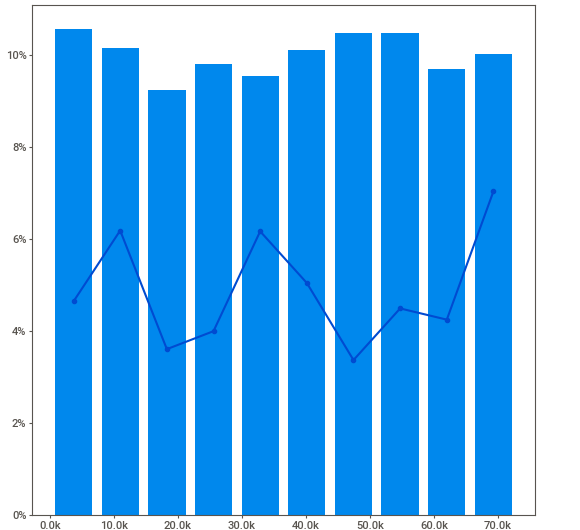
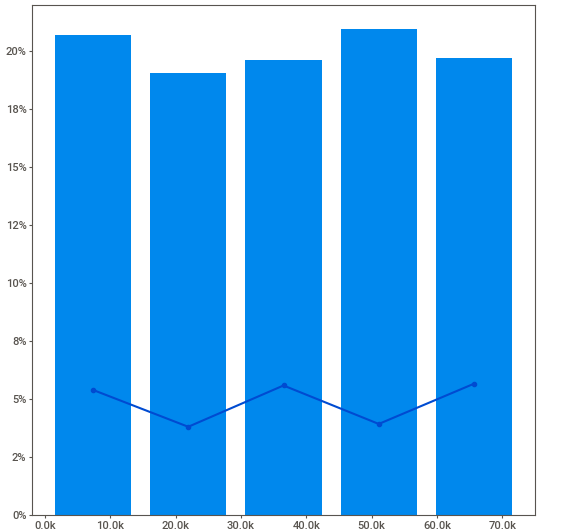
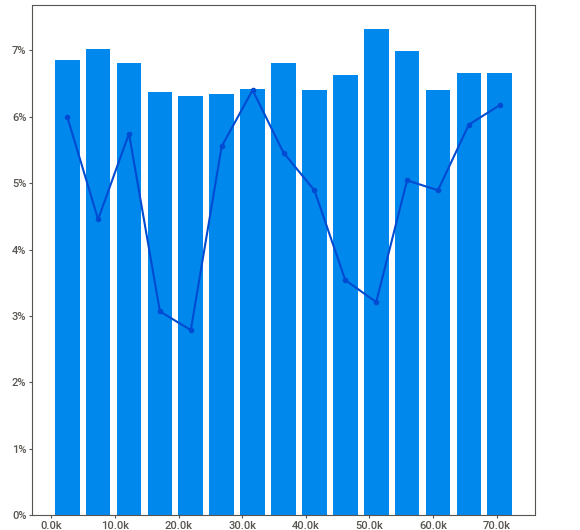
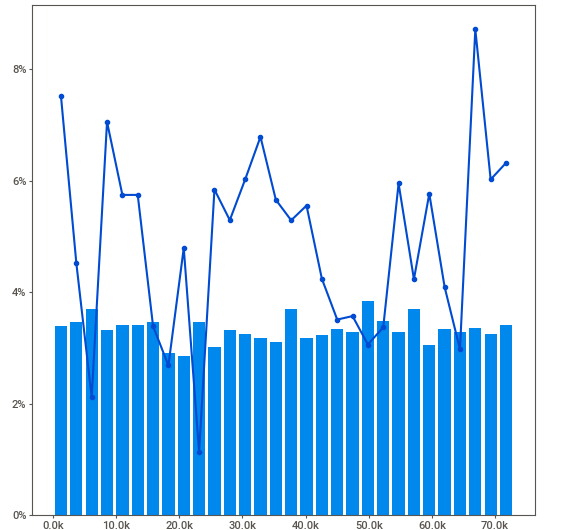
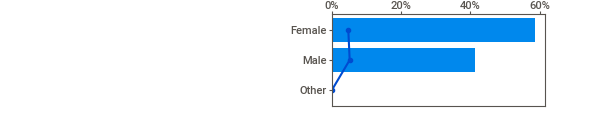
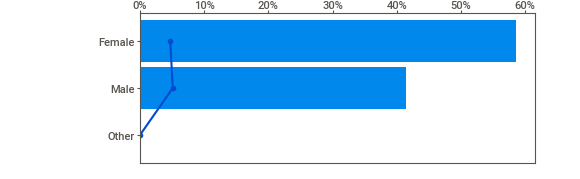
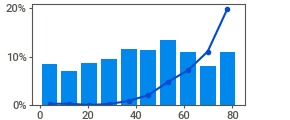
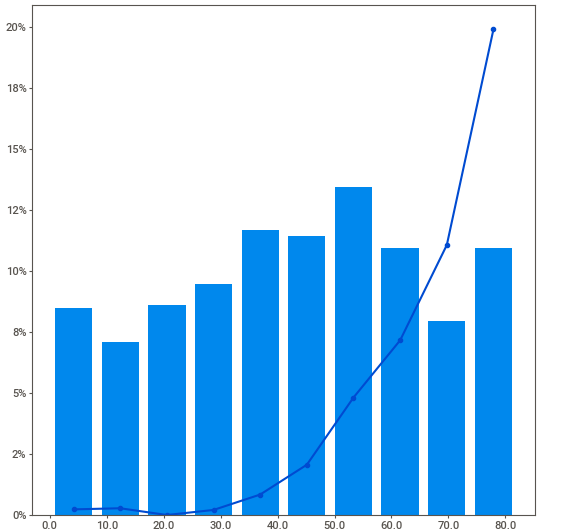
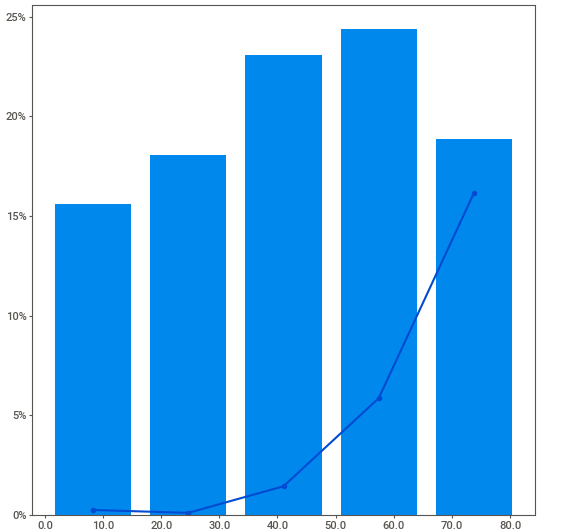
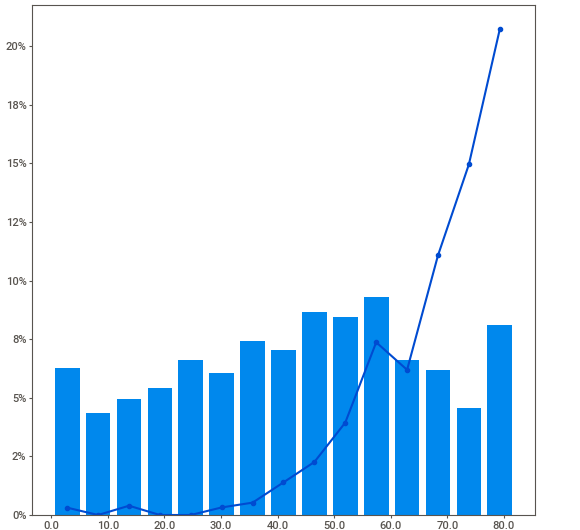
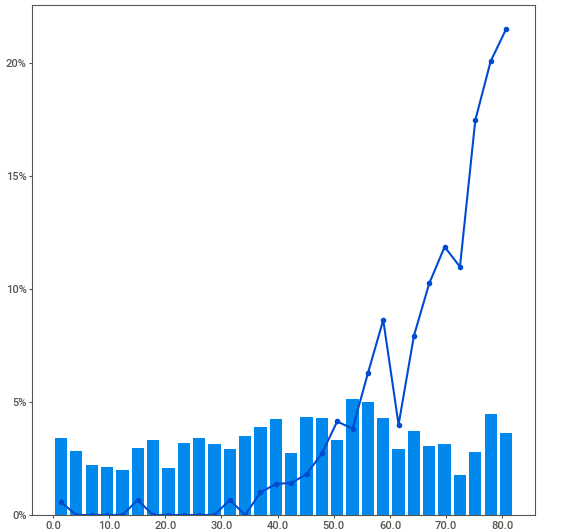
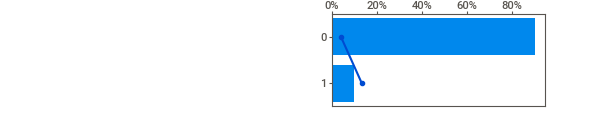
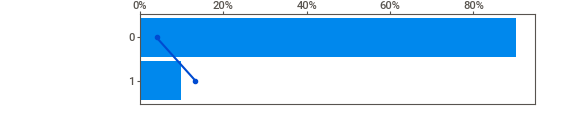
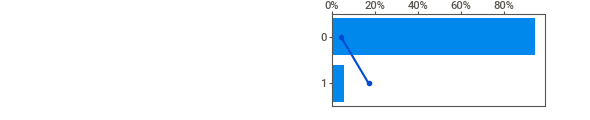
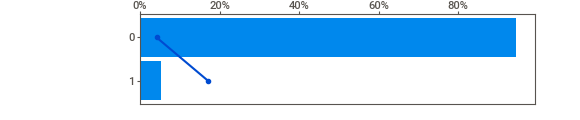
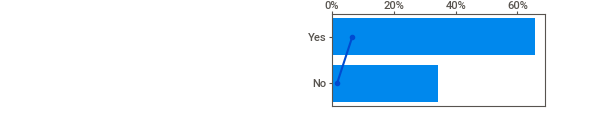
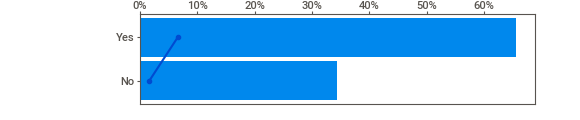
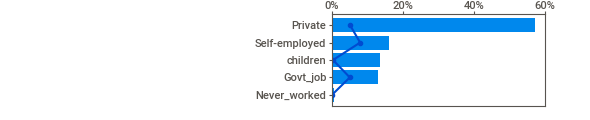
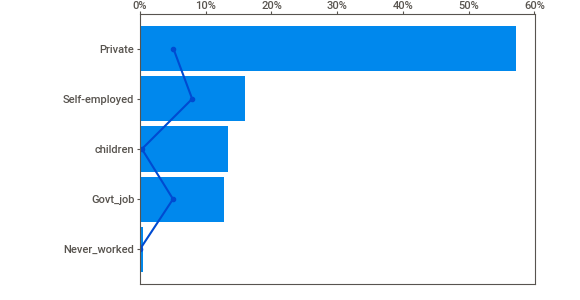
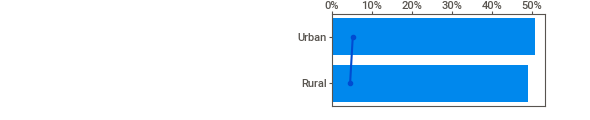
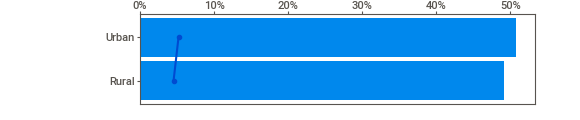
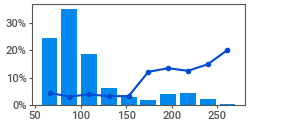
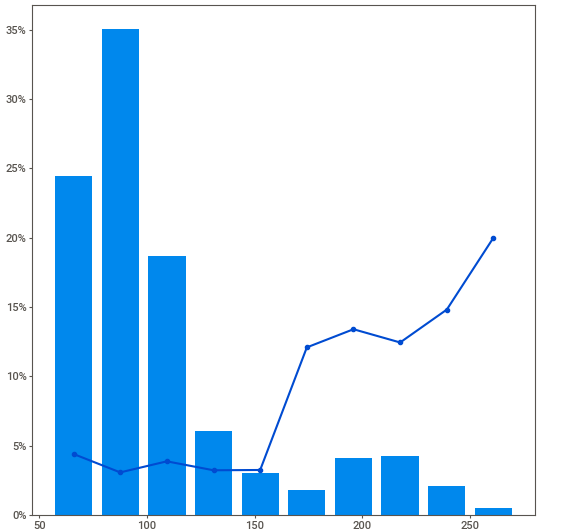
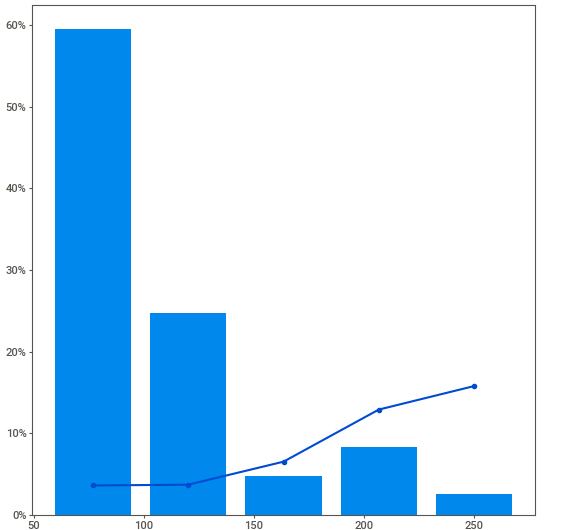
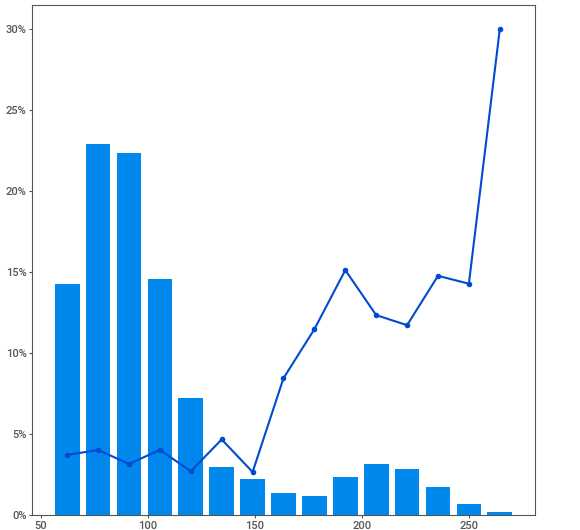
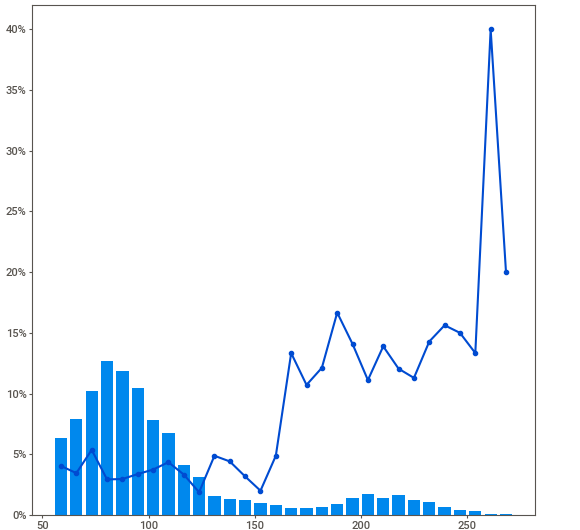
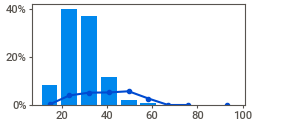
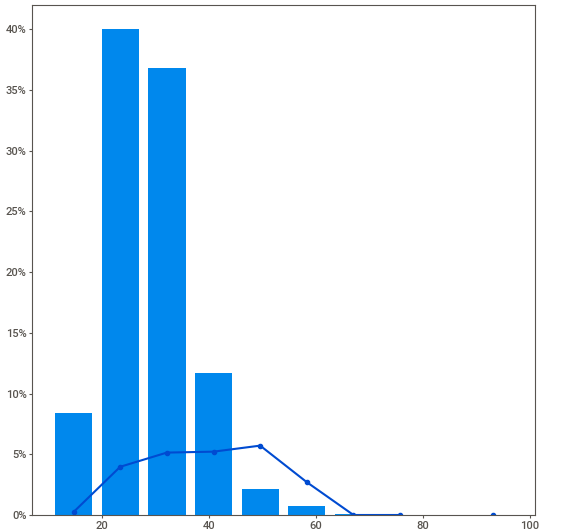
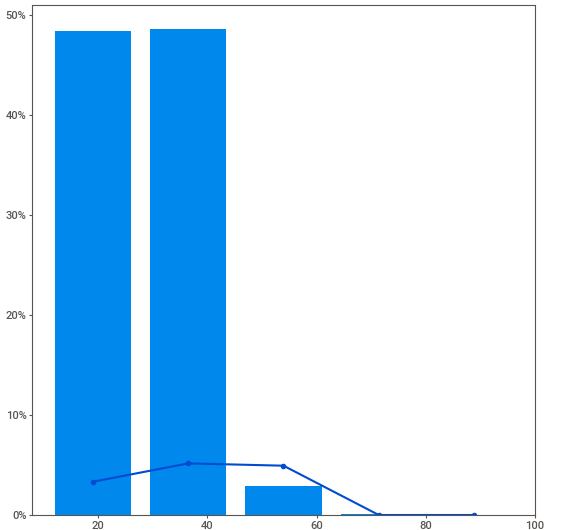
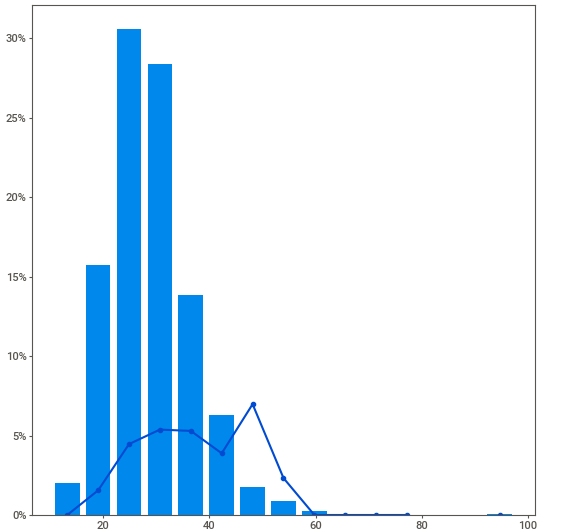
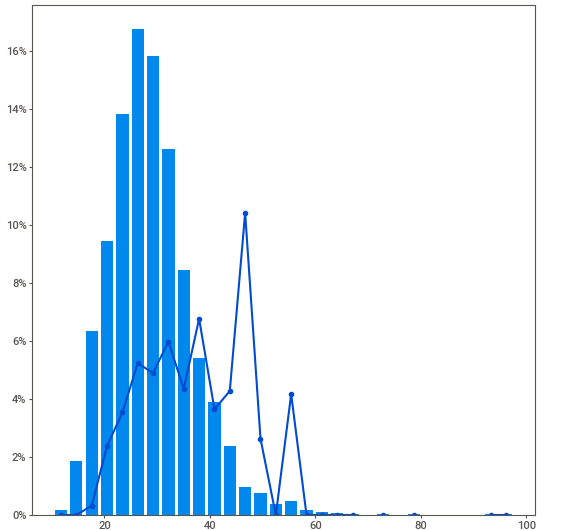
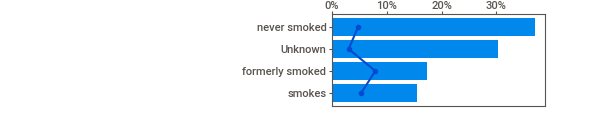
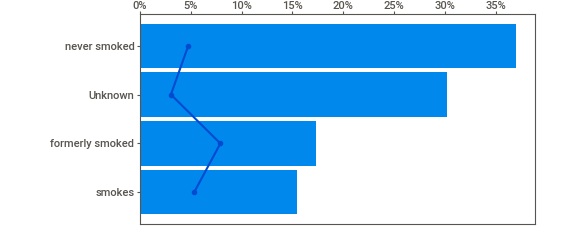
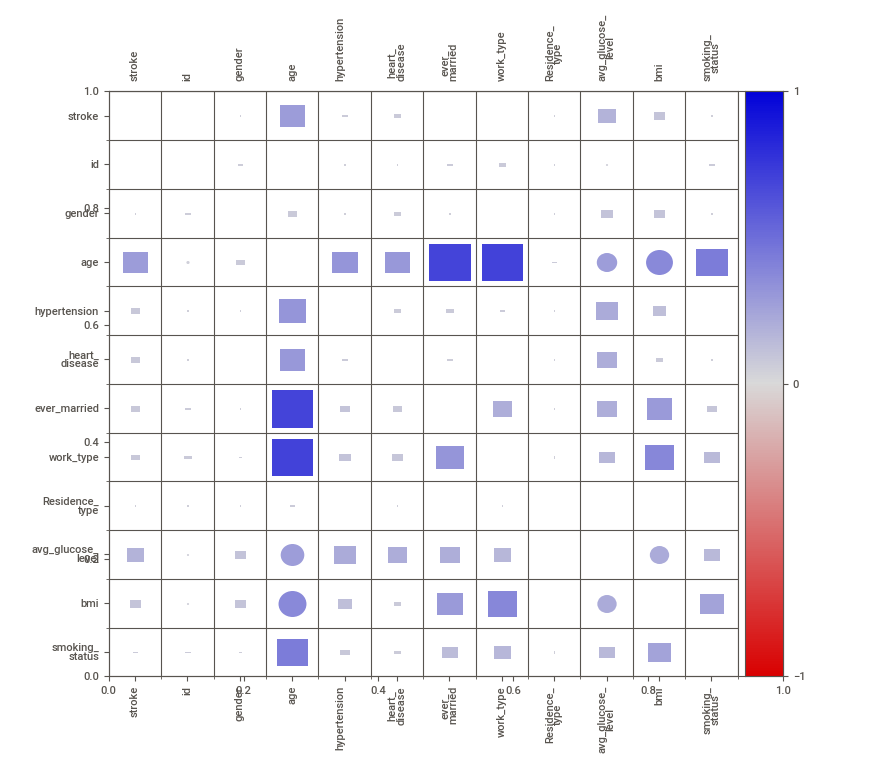
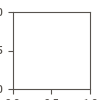

In [ ]:
import sweetviz as sv

eda = sv.analyze(source = df_stroke, target_feat = 'stroke')
eda.show_notebook()

Inicialmente foi realizada uma verificação de NAs (dados faltantes), essas observações foram dropadas.

In [ ]:
print(df_stroke.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [ ]:
nas = df_stroke.isnull().sum().sum()
total_observacoes = df_stroke.shape[0]
print(f'{round(nas/total_observacoes * 100, 2)}% das observações contém NA.')

3.93% das observações contém NA.


In [ ]:
df_stroke = df_stroke.dropna()

- A variável ID foi dropada do conjunto de dados por sua irrelevância na predição de AVC.

- Na variável gênero, "Other" foi removido para manter parcimônia, já que só contem 1 observação.

In [ ]:
df_stroke = df_stroke.drop(columns=["id"])
df_stroke = df_stroke[df_stroke['gender'] != 'Other']
df_stroke['gender'] = df_stroke['gender'].map({'Male': 1, 'Female': 0})

In [ ]:
df_stroke['ever_married'] = df_stroke['ever_married'].map({'Yes': 1, 'No': 0})
df_stroke['Residence_type'] = df_stroke['Residence_type'].map({'Urban': 1, 'Rural': 0})

Aqui faremos a dummificazao de "work_type', juntamente com a retirada de "Never_worked", que representa uma quantidade ínfima de observações.

In [ ]:
df_stroke = df_stroke[df_stroke['work_type'] != 'Never_worked']
df_stroke = pd.get_dummies(df_stroke, columns=['work_type'], drop_first=True)

Aqui também faremos a dumificação de "smoking_status", mantendo as observações de "Unknown" para evitar perda de informação.

In [ ]:
df_stroke = pd.get_dummies(df_stroke, columns=['smoking_status'], drop_first=True)

O tratamento padrão para as variáveis contínuas (e até a discreta idade em anos completos) será a padronização, para manter essas variáveis em escala semelhante, com média 0 e desvio padrão 1.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

colunas_novas = ['age_scaled', 'bmi_scaled', 'avg_glucose_level_scaled']
colunas_antigas = ['age', 'bmi', 'avg_glucose_level']

df_stroke[colunas_novas] = scaler.fit_transform(df_stroke[colunas_antigas])

Aqui serão feitas as transformações finais, dropando as colunas antigas e convertendo Trues e Falses em 1's e 0's

In [ ]:
df_stroke = df_stroke.drop(columns=colunas_antigas)

In [ ]:
colunas_booleanas = df_stroke.select_dtypes(include='bool').columns
df_stroke[colunas_booleanas] = df_stroke[colunas_booleanas].astype(int)

## Modelagem dos dados

In [ ]:
!pip install lightgbm --quiet

# PyCaret

In [ ]:
!pip install pycaret -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

In [ ]:
from pycaret.classification import *

In [ ]:
import pandas as pd
df_stroke = pd.read_excel("df_stroke.xlsx")

In [ ]:
setup(data = df_stroke, target = 'stroke')

,Description,Value
0,Session id,1130
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(4886, 15)"
4,Transformed data shape,"(4886, 15)"
5,Transformed train set shape,"(3420, 15)"
6,Transformed test set shape,"(1466, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


In [ ]:
modelos = compare_models( )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9573,0.8221,0.0000,0.0000,0.0000,0.0000,0.0000,0.9970
svm,SVM - Linear Kernel,0.9573,0.7048,0.0000,0.0000,0.0000,0.0000,0.0000,0.0390
ridge,Ridge Classifier,0.9573,0.8140,0.0000,0.0000,0.0000,0.0000,0.0000,0.0310
dummy,Dummy Classifier,0.9573,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0270
rf,Random Forest Classifier,0.9570,0.7551,0.0000,0.0000,0.0000,-0.0005,-0.0011,0.3380
ada,Ada Boost Classifier,0.9558,0.7684,0.0000,0.0000,0.0000,-0.0026,-0.0044,0.1810
knn,K Neighbors Classifier,0.9550,0.5802,0.0067,0.0500,0.0118,0.0068,0.0109,0.0800
gbc,Gradient Boosting Classifier,0.9547,0.8054,0.0071,0.1000,0.0133,0.0075,0.0167,0.4990
et,Extra Trees Classifier,0.9526,0.7104,0.0071,0.0333,0.0118,0.0031,0.0027,0.2730
lda,Linear Discriminant Analysis,0.9520,0.8141,0.0490,0.1758,0.0741,0.0609,0.0736,0.0310


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
!pip install imbalanced-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 53.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-learn 1.6.1 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score
from scipy.stats import randint
import numpy as np


X = df_stroke.drop('stroke', axis=1)
y = df_stroke['stroke']

smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)


X_trn, X_tst, y_trn, y_tst = train_test_split(
    X_res, y_res, test_size=0.15, stratify=y_res
)


modelo = RandomForestClassifier()

param_distribuicoes = {
    "n_estimators": randint(100, 600),
    "max_depth": randint(5, 60),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 5),
    "bootstrap": [True, False]
}

scoring = {
    'f1': 'f1',
    'recall': 'recall',
    'accuracy': 'accuracy'
}

kfold = KFold(n_splits=5, shuffle=True)

random_search = RandomizedSearchCV(
    estimator       = modelo,
    param_distributions = param_distribuicoes,
    n_iter          = 100, #2
    scoring         = scoring,
    refit           = 'f1',
    cv              = kfold,
    verbose         = 1,
    n_jobs          = -1
)


random_search.fit(X_trn, y_trn)

print(f"Melhores hiperparâmetros encontrados: \n{random_search.best_params_}")

y_pred = random_search.best_estimator_.predict(X_tst)

acc   = accuracy_score(y_tst, y_pred)
rec   = recall_score(y_tst, y_pred)
f1    = f1_score(y_tst, y_pred)

print(f"Acuracia: {acc * 100:.2f}%")
print(f"Recall:   {rec * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Melhores hiperparâmetros encontrados: 
{'bootstrap': False, 'max_depth': 26, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 317}
Acuracia: 95.30%
Recall:   97.58%
F1: 95.40%


## Armazenamento do df, scaler e modelo

In [ ]:
import joblib
joblib.dump(scaler, 'scaler_variaveis.pkl')
df_stroke.to_excel("df_stroke.xlsx", index=False)
joblib.dump(random_search.best_estimator_, 'modelo_otimizado.pkl')
joblib.dump(random_search.best_estimator_, 'modelo_otimizado_comprimido.pkl', compress=3)

['modelo_otimizado_comprimido.pkl']